In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Python/GAN'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import os
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage import io
from tqdm.notebook import tqdm as progress_bar

In [37]:
def build_mnist_discriminator() -> tf.keras.Sequential:
    """
    :return: compiled discriminator model for generating hand written digits
    """
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model


def build_mnist_generator(latent_dim: int = 100) -> tf.keras.Sequential:
    """
    :return: generator model for generating hand written digits
    """
    model = tf.keras.Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((7, 7, 128)))
    # up sample to 14x14
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # up sample to 28x28
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(1, (7, 7), activation="sigmoid", padding="same"))
    return model

def build_mnist_gan(generator, discriminator):
    discriminator.trainable = False

    model = tf.keras.Sequential([generator, discriminator, ])
    
    adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=adam)
 
    return model


In [4]:
class MNISTDataSet:
    """
    Class holds MNIST data set generator implementation
    Full data set is stored in memory
    """
    def __init__(self, data_set: pd.DataFrame):
        """
        :param data_set: pandas DataFrame with MNIST images
        """
        self.features = data_set.loc[:, "pixel0": "pixel783"]
        self.labels = data_set["label"]
        self.n_data_points = data_set.index.size

    @classmethod
    def from_csv(cls, path: str):
        """
        :param path: relative path to .csv file with data set

        :return: MNISTDataSet object constructed from file
        """
        data_set = pd.read_csv(path)
        return cls(data_set)

    @staticmethod
    def _prepare_images(samples: np.array) -> np.array:
        """
        Prepare data rows to be used by neural network
        Reshape and rescale values
        """
        samples = samples.reshape(len(samples), 28, 28)
        samples = np.expand_dims(samples, axis=-1)
        samples = samples.astype("float32")
        samples = samples / 255.0

        return samples

    def real_batch(self, size: int = 32) -> np.array:
        """
        :param size: number of images

        :return: batch of real data samples
        """
        sample_ids = np.random.randint(0, self.n_data_points, size)
        samples = self.features.iloc[sample_ids].values

        return self._prepare_images(samples), np.ones((size, 1))

    def latent_batch(self, size: int = 32, latent_dim: int = 100) -> np.array:
        """
        :param size: number of images
        :param latent_dim: dimension of latent random distribution

        :return: batch of real data samples
        """
        inputs = np.random.randn(latent_dim * size)
        inputs = inputs.reshape(size, latent_dim)

        return inputs

    def batch(self, samples: np.array, size: int = 32) -> tuple:
        """
        Generate batch for GAN training

        :param samples: generated by generator network
        :param size: batch size

        :return: tuple of features and labels for GAN training with real and generated data points
        """
        real_x, real_y = self.real_batch(size // 2)
        generated_x, generated_y = samples, np.zeros((size // 2, 1))

        x, y = np.vstack([real_x, generated_x]), np.vstack([real_y, generated_y])
        ordering = np.random.permutation(len(x))

        return x[ordering], y[ordering]


In [24]:
class GenerativeAdversarialNetwork:
    """
    Class holding interface for Generative Adversarial Network
    """
    def __init__(self, generator_build_fn: callable, discriminator_build_fn: callable):
        """
        :param generator_build_fn: function which returns compiled generator model
        :param discriminator_build_fn:  function which returns compiled discriminator model
        """
        self.generator = generator_build_fn()
        self.discriminator = discriminator_build_fn()

        generator = generator_build_fn()
        discriminator = discriminator_build_fn()

        discriminator.trainable = False

        self.model = tf.keras.Sequential([generator, discriminator, ])

    def compile(self, loss="binary_crossentropy", optimizer=None, **kwargs) -> None:
        """Compile model with default parameters"""
        optimizer = optimizer or tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        self.model.compile(loss=loss, optimizer=optimizer, **kwargs)

    def fit(
        self, data_set, latent_dim: int, epochs: int, batch_size=256, callbacks: tuple = (), silent: bool = False
    ) -> None:
        """
        Run Adversarial training of the model

        :param data_set: data set interface object generating desired data set
        :param latent_dim: dimension of latent space used to generate samples
        :param epochs: number of epochs to train for
        :param batch_size: number of data points in single batch
        :param callbacks: list of callbacks to control verbosity and early stopping
        :param silent: if False print progress bar
        """
        n_batches_in_epoch = int(data_set.n_data_points / batch_size)
        for epoch in progress_bar(range(epochs), disable=silent):
            for batch_index in range(n_batches_in_epoch):
                # set-up data batch
                samples = self.generator(data_set.latent_batch(batch_size // 2))
                x, y = data_set.batch(samples, size=batch_size)
                # train discriminator
                discriminator_loss, _ = self.discriminator.train_on_batch(x, y)
                # train generator
                inputs = data_set.latent_batch(size=batch_size, latent_dim=latent_dim)
                labels = np.ones([batch_size, 1])
                self.model.train_on_batch(inputs, labels)

        for callback in callbacks:
            terminate = callback.on_epoch_end(self.generator)
            if terminate:
                return

    def generate(self, samples: np.array) -> np.array:
        """
        :return: return data points generated by the model
        """
        return self.generator.predict(samples)

    def discriminate(self, samples: np.array) -> np.array:
        """
        :return: discrimination result for given samples
        """
        return np.argmanx(self.discriminator.predict(samples), axis=1)

    def discriminate_probability(self, samples: np.array) -> np.array:
        """
        :return: discrimination scores for given samples
        """
        return self.discriminator.predict(samples)


In [38]:
def fit(model, generator, discriminator, data_set, latent_dim: int, epochs: int, batch_size=256, callbacks: tuple = (), silent: bool = False) -> None:
    """
    Run Adversarial training of the model

    :param data_set: data set interface object generating desired data set
    :param latent_dim: dimension of latent space used to generate samples
    :param epochs: number of epochs to train for
    :param batch_size: number of data points in single batch
    :param callbacks: list of callbacks to control verbosity and early stopping
    :param silent: if False print progress bar
    """
    n_batches_in_epoch = int(data_set.n_data_points / batch_size)
    for epoch in progress_bar(range(epochs), disable=silent):
        for batch_index in range(n_batches_in_epoch):
            # set-up data batch
            samples = generator(data_set.latent_batch(batch_size // 2))
            x, y = data_set.batch(samples, size=batch_size)
            # train discriminator
            discriminator_loss, _ = discriminator.train_on_batch(x, y)
            # train generator
            inputs = data_set.latent_batch(size=batch_size, latent_dim=latent_dim)
            labels = np.ones([batch_size, 1])
            model.train_on_batch(inputs, labels)

    for callback in callbacks:
        terminate = callback.on_epoch_end(generator)
        if terminate:
            return

In [25]:
def show_generated_batch(images):
    figure, axes = plt.subplots(2, 4, figsize=[32, 12])

    for (x, y), image in zip(product(range(2), range(4)), images):
        axes[x, y].imshow(image[:, :, 0], cmap="Greys")


class GANCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(GANCallback, self).__init__()

    def on_epoch_end(self):
        ...

    @staticmethod
    def _show_generated_batch(images):
        figure, axes = plt.subplots(2, 4, figsize=[32, 12])

        for (x, y), image in zip(product(range(2), range(4)), images):
            axes[x, y].imshow(image[:, :, 0], cmap="Greys")


In [40]:
mnist_data_set = MNISTDataSet.from_csv(os.path.join(root_path, "train.csv"))

generator = build_mnist_generator()
discriminator = build_mnist_discriminator()
gan = build_mnist_gan(generator, discriminator)

In [42]:
fit(model=gan, generator=generator, discriminator=discriminator, data_set=mnist_data_set, latent_dim=100, epochs=40)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [44]:
generated = generator(mnist_data_set.latent_batch(size=8, latent_dim=100))

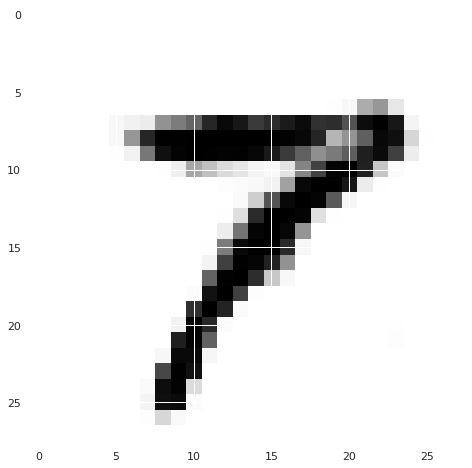

In [45]:
_ = plt.figure(figsize=[8, 8])
_ = plt.imshow(generated[1][:, :, 0], cmap="Greys")